In [56]:
from entsoe import EntsoePandasClient
import pandas as pd
import matplotlib.pyplot as plt

# Electricity market data

## Get electricity market data via Entso-E API

In [46]:
# Define key and client
my_key = 'Hier den API Key einfügen'
client = EntsoePandasClient(api_key=my_key)

# Define time horizon and geographical area
start = pd.Timestamp('2024-01-01 00:00', tz='Europe/Brussels')
end = pd.Timestamp('2024-12-31 23:59', tz='Europe/Brussels')
country_code = 'DE_LU'

# Day ahead prices will be imported as series
day_ahead_prices = client.query_day_ahead_prices(country_code, start=start, end=end)

# Convert to df and name columns
day_ahead_prices = day_ahead_prices.to_frame(name='Price')
day_ahead_prices.index.name = 'Time'

# name the df with the defined parameters
day_ahead_prices.name = f'day_ahead_price_{country_code}_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}'

## Plot Day-Ahead Prices over time

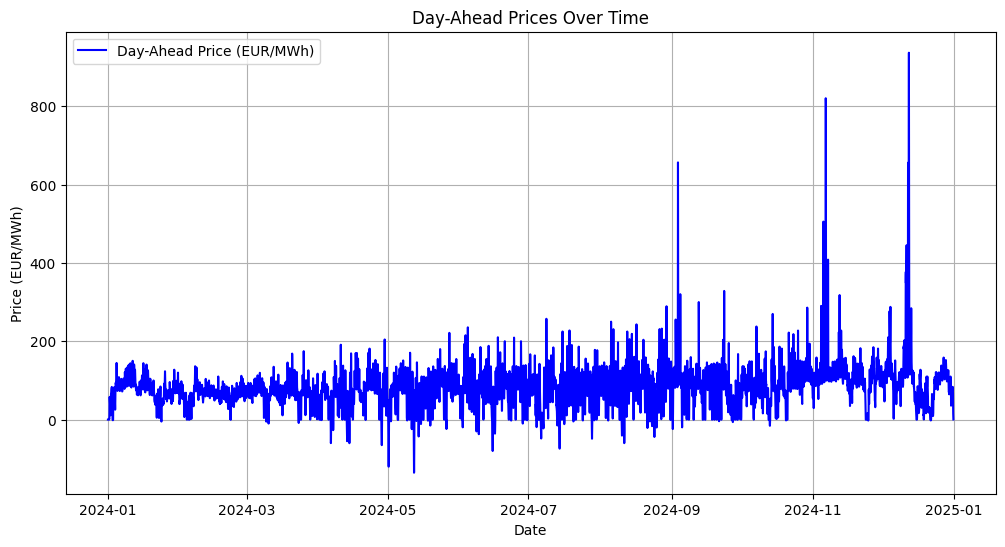

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(day_ahead_prices.index, day_ahead_prices['Price'], color='blue', label='Day-Ahead Price (EUR/MWh)')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.title('Day-Ahead Prices Over Time')
plt.legend()
plt.grid(True)

plt.show()

# representative days for each month

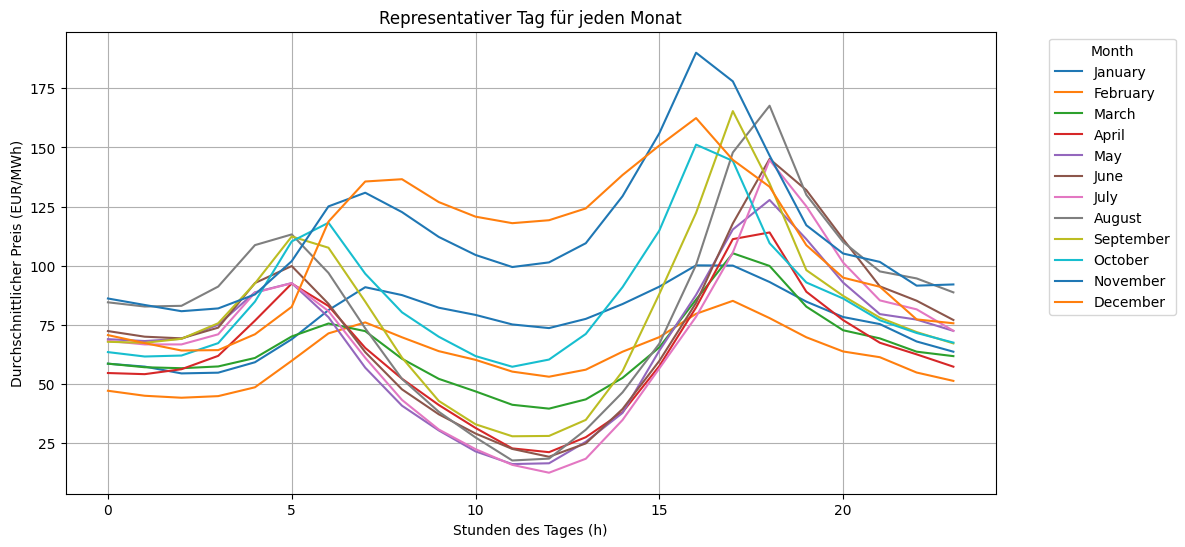

In [48]:
# Inspecting the index to check for correct datetime format
day_ahead_prices.index = pd.to_datetime(day_ahead_prices.index, utc=True)  # Ensuring datetime format

# Splitting the data into separate DataFrames for each month
monthly_dfs = {month: df for month, df in day_ahead_prices.groupby(day_ahead_prices.index.month)}

# Creating representative days for each month
representative_days = {}

for month, df in monthly_dfs.items():
    # Group by hour of the day and calculate the average price for that hour across the month
    df = df.copy()
    df['Hour'] = df.index.hour
    representative_day = df.groupby('Hour').mean()
    representative_days[month] = representative_day

# Creating a new DataFrame with all representative days
final_df = pd.concat(representative_days, keys=representative_days.keys())
final_df.index.names = ['Month', 'Hour']

# Mapping month numbers to month names
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# Renaming the index to use month names
final_df_named = final_df.rename(index=month_names, level=0)

# Reset index for plotting
final_df_reset_named = final_df_named.reset_index()

# Plotting with month names
plt.figure(figsize=(12, 6))
for month in month_names.values():
    plt.plot(final_df_reset_named[final_df_reset_named['Month'] == month]['Hour'],
             final_df_reset_named[final_df_reset_named['Month'] == month]['Price'],
             label=month)

plt.xlabel("Stunden des Tages (h)")
plt.ylabel("Durchschnittlicher Preis (EUR/MWh)")
plt.title("Representativer Tag für jeden Monat")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# PV-Data

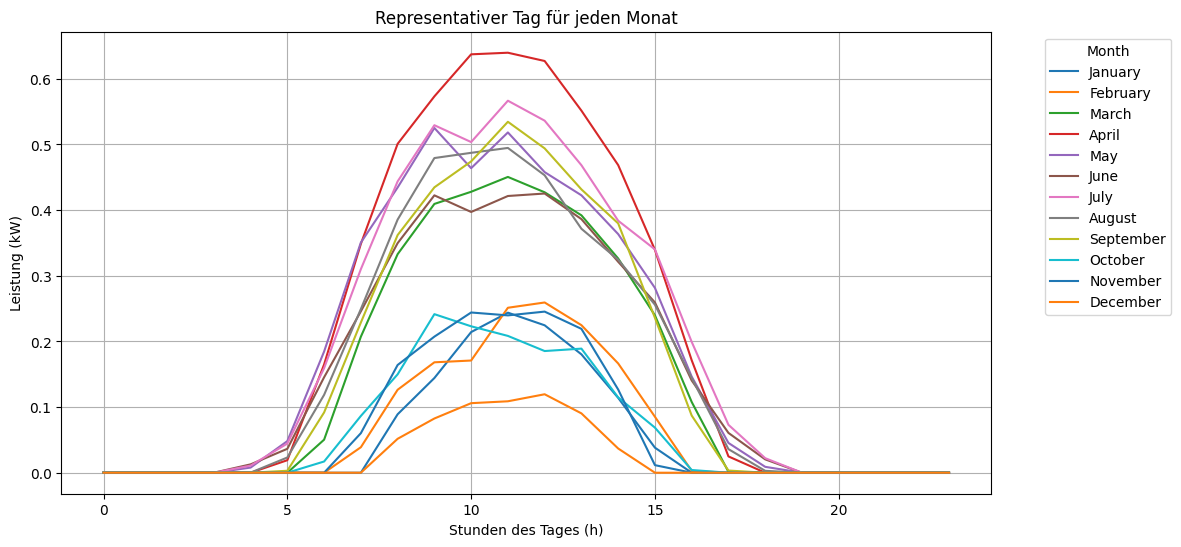

PV Generation Data saved as 'pv_generation_bayreuth.csv'


In [49]:
import requests
# PVGIS API Endpoint
PVGIS_API_URL = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

# Define location (Bayreuth, Germany)
latitude = 49.9481
longitude = 11.5789

# Parameters for PVGIS API request
params = {
    "lat": latitude,
    "lon": longitude,
    "startyear": 2020,
    "endyear": 2020,
    "outputformat": "json",
    "pvcalculation": 1,
    "loss": 15,  # Assumed system losses in %
    "peakpower": 1,  # Normalized to 1 kW installed capacity
    "mountingplace": "free",  # Ground-mounted PV
    "angle": 35,  # Optimal tilt angle for Germany
    "aspect": 0,  # South-facing
}

# Fetch data from PVGIS API
response = requests.get(PVGIS_API_URL, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract energy generation data
    time_series = data["outputs"]["hourly"]
    df = pd.DataFrame(time_series)

    # Convert timestamp to datetime format
    df["time"] = pd.to_datetime(df["time"], format="%Y%m%d:%H%M")
    df.set_index("time", inplace=True)

    # Rename the relevant column for clarity
    df.rename(columns={"P": "Power [W]"}, inplace=True)

    # Convert from Watts to kW
    df["Power [kW]"] = df["Power [W]"] / 1000  # Convert W to kW

    # Splitting the data into separate DataFrames for each month
    monthly_pv_dfs = {month: df for month, df in df.groupby(df.index.month)}

    # Creating representative days for each month
    representative_pv_days = {}

    for month, df in monthly_pv_dfs.items():
        df = df.copy()
        df["Hour"] = df.index.hour
        representative_day = df.groupby("Hour").mean()
        representative_pv_days[month] = representative_day

    # Creating a new DataFrame with all representative days
    pv_final_df = pd.concat(representative_pv_days, keys=representative_pv_days.keys())
    pv_final_df.index.names = ["Month", "Hour"]

    # Mapping month numbers to names
    month_names = {
        1: "January", 2: "February", 3: "March", 4: "April",
        5: "May", 6: "June", 7: "July", 8: "August",
        9: "September", 10: "October", 11: "November", 12: "December"
    }
    pv_final_df_named = pv_final_df.rename(index=month_names, level=0)

    # Reset index for plotting
    pv_final_df_reset = pv_final_df_named.reset_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    for month in month_names.values():
        plt.plot(pv_final_df_reset[pv_final_df_reset["Month"] == month]["Hour"],
                 pv_final_df_reset[pv_final_df_reset["Month"] == month]["Power [kW]"],
                 label=month)

    plt.xlabel("Stunden des Tages (h)")
    plt.ylabel("Leistung (kW)")
    plt.title("Representativer Tag für jeden Monat")
    plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

    # Save the dataset
    pv_final_df_named.to_csv("pv_generation_bayreuth.csv")
    print("PV Generation Data saved as 'pv_generation_bayreuth.csv'")

else:
    print(f"API Request Failed: {response.status_code}, {response.text}")


## Yearly summary of PV-data

In [50]:
# Ensure Power [kW] column is numeric
pv_final_df_named["Power [kW]"] = pd.to_numeric(pv_final_df_named["Power [kW]"], errors='coerce')

# Summing the total energy output for each month
monthly_energy_output = pv_final_df_named.groupby(level=0)["Power [kW]"].sum()

# Dictionary of number of days per month
days_in_month = {
    "January": 31, "February": 29, "March": 31, "April": 30,
    "May": 31, "June": 30, "July": 31, "August": 31,
    "September": 30, "October": 31, "November": 30, "December": 31
}

# Creating a new dataframe with month index, summed power values, and days in the month
monthly_summary_df = pd.DataFrame({
    "Total Power [kW]": monthly_energy_output,
    "Days in Month": [days_in_month[month] for month in monthly_energy_output.index]
})

# Creating the third column with the multiplication of Power [kW] and Days
monthly_summary_df["Total Energy (kWh/kW installed)"] = (
    monthly_summary_df["Total Power [kW]"] * monthly_summary_df["Days in Month"]
)

monthly_summary_df.head(12)

monthly_summary_df.to_csv("monthly_pv_energy_summary.csv")

## Plot PV-Summary

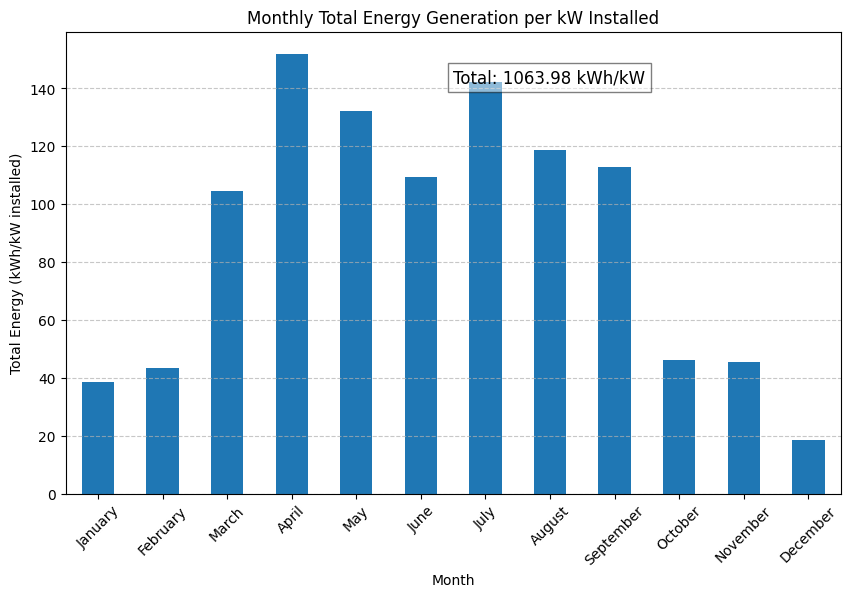

In [51]:
# Define the correct month order
month_order = ["January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"]

# Sort the DataFrame according to the correct month order
monthly_summary_df_sorted = monthly_summary_df.reindex(month_order)

# Calculate the sum of the "Total Energy (kWh/kW installed)" column
yearly_generation = monthly_summary_df_sorted["Total Energy (kWh/kW installed)"].sum()

# Plot the data
plt.figure(figsize=(10, 6))
monthly_summary_df_sorted["Total Energy (kWh/kW installed)"].plot(kind='bar')

# Add a textbox with the yearly generation sum
plt.text(0.5, 0.9, f'Total: {yearly_generation:.2f} kWh/kW', 
            horizontalalignment='left', verticalalignment='center', 
            transform=plt.gca().transAxes, fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.5))

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Total Energy (kWh/kW installed)')
plt.title('Monthly Total Energy Generation per kW Installed')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Merge PV and Electricity market data

In [52]:
# Define the scaling factor of PV generation
s = 1000  # kW installed capacity

# Extract the required columns from pv_final_df_reset
pv_data = pv_final_df_reset[["Power [kW]", "Hour", "Month"]]

# Scale the "Power [kW]" values
pv_data["Power [kW]"] = pv_data["Power [kW]"] * s

# Extract the required column from final_df_reset_named
price_data = final_df_reset_named[["Price", "Hour", "Month"]]

# Merge the DataFrames on "Hour" and "Month"
merged_df = pd.merge(pv_data, price_data, on=["Hour", "Month"])

merged_df.to_csv("merged_data.csv", index=False)

merged_df.head(26)

/var/folders/hc/6v0wq61n6sjg73dt81ctkmhm0000gn/T/ipykernel_2375/2400778339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_data["Power [kW]"] = pv_data["Power [kW]"] * s


,Power [kW],Hour,Month,Price
0,0.000000,0,January,58.586452
1,0.000000,1,January,57.360000
2,0.000000,2,January,54.486452
3,0.000000,3,January,54.794194
4,0.000000,4,January,59.201613
5,0.000000,5,January,68.921935
6,0.000000,6,January,81.236774
7,0.000000,7,January,90.916774
8,89.014839,8,January,87.581613
9,144.264839,9,January,82.250968


# Solve for optimal BESS size

In [53]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd

# note: LCOS (levelized cost of storage) is not used, it's just a stand-in for CAPEX. 

def optimize_storage_for_pv_constraintlist_power_rating(df, s):

    # Battery parameters
    battery_lcos = 15000.0       # €/MWh of capacity
    battery_lifetime = 20        # years
    battery_efficiency = 0.95

    # PV parameters
    pv_invest_cost = 794.0      # €/kW
    pv_lifetime = 30             # years
    pv_cost = (s * pv_invest_cost) / pv_lifetime  # annualized

    model = pyo.ConcreteModel()

    # Set of time periods
    model.T = pyo.Set(initialize=df.index)

    # Price and PV Generation as Pyomo Params
    def _init_price(m, t):
        return float(df.loc[t, 'Price'])
    model.price = pyo.Param(model.T, initialize=_init_price, default=0.0)

    def _init_pv(m, t):
        return float(df.loc[t, 'PV_Gen'])
    model.pv_gen = pyo.Param(model.T, initialize=_init_pv, default=0.0)

    model.batt_eta = pyo.Param(initialize=battery_efficiency)

    # Variables
    model.battery_energy = pyo.Var(domain=pyo.NonNegativeReals)  # MWh
    model.battery_power  = pyo.Var(domain=pyo.NonNegativeReals)  # MW

    model.soc          = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # MWh each period
    model.charge       = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # MW each period
    model.discharge    = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # MW each period
    model.sell_direct  = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # MW
    model.sell_storage = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # MW

    # Objective: maximize revenue - costs
    def objective_rule(m):
        direct_revenue = sum(m.price[t] * m.sell_direct[t] for t in m.T)
        storage_revenue = sum(m.price[t] * m.sell_storage[t] for t in m.T)
        annual_battery_cost = (m.battery_energy * battery_lcos) / battery_lifetime

        return (
            direct_revenue
            + storage_revenue
            - annual_battery_cost
            - pv_cost
        )
    model.OBJ = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

    # Constraints

    # 1) PV balance: sell_direct + charge <= PV_Gen
    model.PvBalance = pyo.ConstraintList()
    for t in model.T:
        model.PvBalance.add(
            model.sell_direct[t] + model.charge[t] <= model.pv_gen[t]
        )

    # 2) State of Charge balance
    model.SocBalance = pyo.ConstraintList()
    sorted_periods = sorted(model.T)
    for i, t in enumerate(sorted_periods):
        if i == 0:
            model.SocBalance.add(
                model.soc[t] == model.charge[t] * model.batt_eta
                                - model.discharge[t] / model.batt_eta
            )
        else:
            prev_t = sorted_periods[i-1]
            model.SocBalance.add(
                model.soc[t] == model.soc[prev_t]
                                + model.charge[t] * model.batt_eta
                                - model.discharge[t] / model.batt_eta
            )

    # 3) SoC <= battery_energy
    model.SocCapacity = pyo.ConstraintList()
    for t in model.T:
        model.SocCapacity.add(
            model.soc[t] <= model.battery_energy
        )

    # 4) Discharge = sell_storage
    model.DischargeSold = pyo.ConstraintList()
    for t in model.T:
        model.DischargeSold.add(
            model.discharge[t] == model.sell_storage[t]
        )

    # 5) Power rating constraints
    model.ChargePowerLimit = pyo.ConstraintList()
    model.DischargePowerLimit = pyo.ConstraintList()
    for t in model.T:
        model.ChargePowerLimit.add(
            model.charge[t] <= model.battery_power
        )
        model.DischargePowerLimit.add(
            model.discharge[t] <= model.battery_power
        )

    # 6) 3:1 ratio constraints for E/P
    model.RatioConstraint1 = pyo.Constraint(expr=model.battery_power  <= 3.0 * model.battery_energy)
    model.RatioConstraint2 = pyo.Constraint(expr=model.battery_energy <= 3.0 * model.battery_power)

    # Solve
    solver = SolverFactory('glpk')
    results = solver.solve(model, tee=False)
    print("Solver status:", results.solver.status)
    print("Termination condition:", results.solver.termination_condition)

    return model


df = merged_df.copy()
df['PV_Gen'] = df['Power [kW]'] / 1000.0  # from kW to MW
model = optimize_storage_for_pv_constraintlist_power_rating(df, s)

# Extract results
optimal_battery_energy = pyo.value(model.battery_energy)
optimal_battery_power  = pyo.value(model.battery_power)

soc_values = [pyo.value(model.soc[t]) for t in model.T]
charge_values = [pyo.value(model.charge[t]) for t in model.T]
discharge_values = [pyo.value(model.discharge[t]) for t in model.T]
sell_direct_values = [pyo.value(model.sell_direct[t]) for t in model.T]
sell_storage_values = [pyo.value(model.sell_storage[t]) for t in model.T]

results_df = df.copy()
results_df["SoC"]          = soc_values
results_df["Charge"]       = charge_values
results_df["Discharge"]    = discharge_values
results_df["Sell_Direct"]  = sell_direct_values
results_df["Sell_Storage"] = sell_storage_values

results_df["Hourly_Revenue"] = (
    results_df["Price"] * results_df["Sell_Direct"]
  + results_df["Price"] * results_df["Sell_Storage"]
)

daily_revenue_by_month = results_df.groupby("Month")["Hourly_Revenue"].sum()

days_in_month = {
    "January": 31, "February": 28, "March": 31, "April": 30, "May": 31, "June": 30,
    "July": 31, "August": 31, "September": 30, "October": 31, "November": 30, "December": 31
}

scaled_revenue_by_month = []
for m in daily_revenue_by_month.index:
    month_revenue = daily_revenue_by_month[m] * days_in_month[m]
    scaled_revenue_by_month.append(month_revenue)

monthly_revenue_df = pd.DataFrame({
    "Month": daily_revenue_by_month.index,
    "RepDay_Revenue": daily_revenue_by_month.values,
    "Days": [days_in_month[m] for m in daily_revenue_by_month.index],
    "Scaled_Monthly_Revenue": scaled_revenue_by_month,
})

total_annual_revenue = monthly_revenue_df["Scaled_Monthly_Revenue"].sum()

# Battery annual cost with single LCOS approach
battery_lifetime = 20
battery_lcos = 15000
battery_cost_annual = (battery_lcos * optimal_battery_energy) / battery_lifetime

# PV cost (annualized)
pv_invest_cost = 794.0 
pv_lifetime = 30
pv_cost = (s * pv_invest_cost) / pv_lifetime

total_annual_profit = total_annual_revenue - battery_cost_annual - pv_cost

# Simple NPV ignoring discounting for demonstration
r = 0.07
NPV_batt = sum(total_annual_profit / ((1 + r) ** year) for year in range(1, battery_lifetime + 1))
NPV_pv = sum(total_annual_profit / ((1 + r) ** year) for year in range(1, pv_lifetime + 1))


print("-" * 60)
print(f"Optimal battery energy (E): {optimal_battery_energy:.2f} MWh")
print(f"Optimal battery power  (P): {optimal_battery_power:.2f} MW")
print("")
print(f"Annual Battery cost:  {battery_cost_annual:,.2f} €")
print(f"Annual PV cost:       {pv_cost:,.2f} €")
print(f"Lifetime PV cost:       {pv_cost*pv_lifetime:,.2f} €")
print(f"Annual Revenue:       {total_annual_revenue:,.2f} €")
print(f"Net Annual Profit:    {total_annual_profit:,.2f} €")
print(f"NPV ({battery_lifetime} yrs @ {r*100:.1f}%): {NPV_batt:,.2f} €")
print(f"NPV ({pv_lifetime} yrs @ {r*100:.1f}%): {NPV_pv:,.2f} €")
print("-" * 60)

print("\nDetailed monthly revenue:")
print(monthly_revenue_df.sort_values("Scaled_Monthly_Revenue", ascending=False))
print("-" * 60)

Solver status: ok
Termination condition: optimal
------------------------------------------------------------
Optimal battery energy (E): 1.41 MWh
Optimal battery power  (P): 1.34 MW

Annual Battery cost:  1,057.53 €
Annual PV cost:       26,466.67 €
Lifetime PV cost:       794,000.00 €
Annual Revenue:       92,354.75 €
Net Annual Profit:    64,830.55 €
NPV (20 yrs @ 7.0%): 686,815.81 €
NPV (30 yrs @ 7.0%): 804,485.01 €
------------------------------------------------------------

Detailed monthly revenue:
        Month  RepDay_Revenue  Days  Scaled_Monthly_Revenue
1      August      357.856023    31            11093.536727
11  September      360.529419    30            10815.882584
5        July      338.269777    31            10486.363083
0       April      324.267451    30             9728.023539
8         May      305.109993    31             9458.409776
6        June      313.811664    30             9414.349906
7       March      253.616093    31             7862.098898
9    Nov

## Plot the results

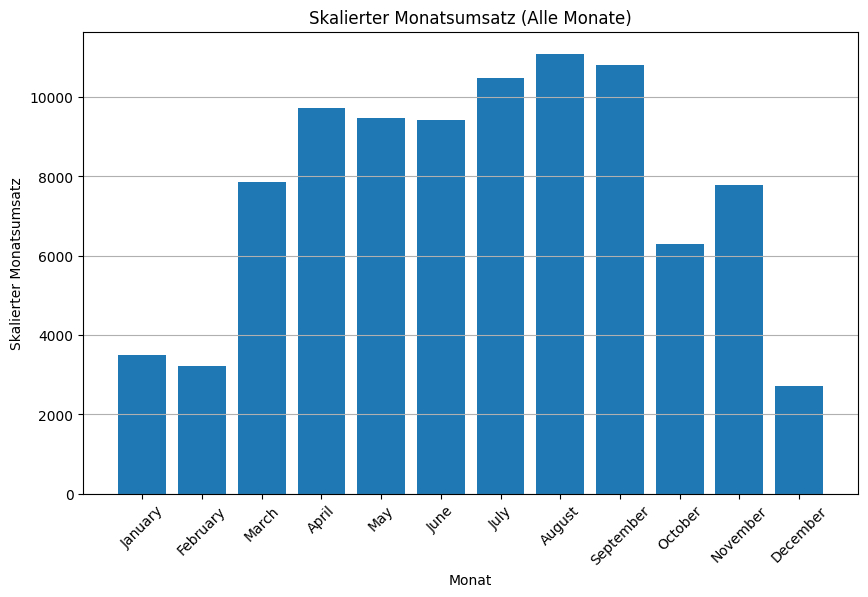

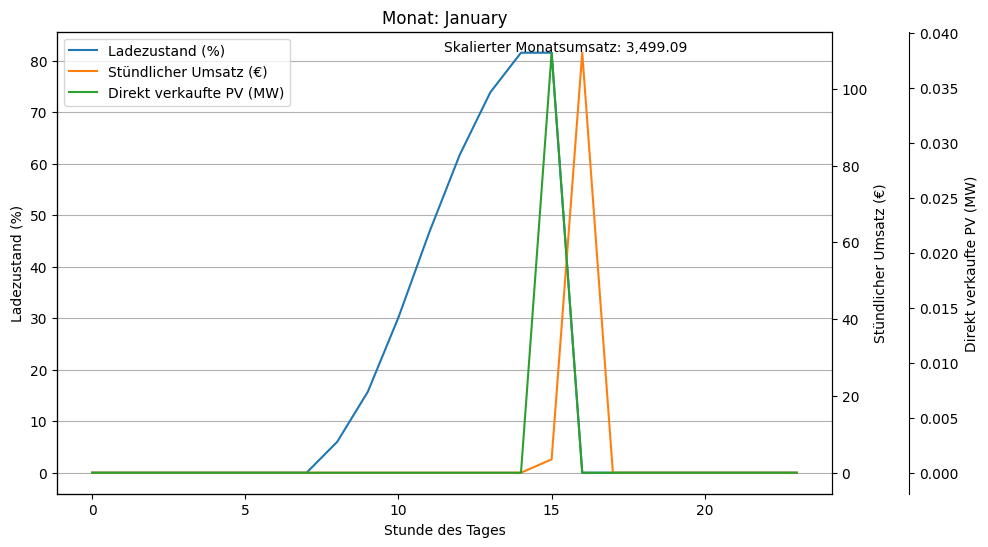

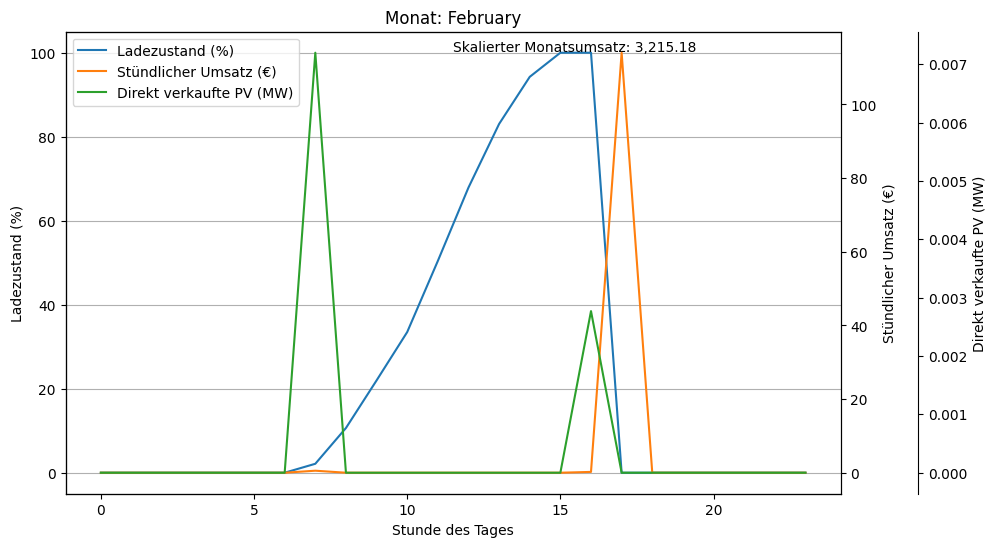

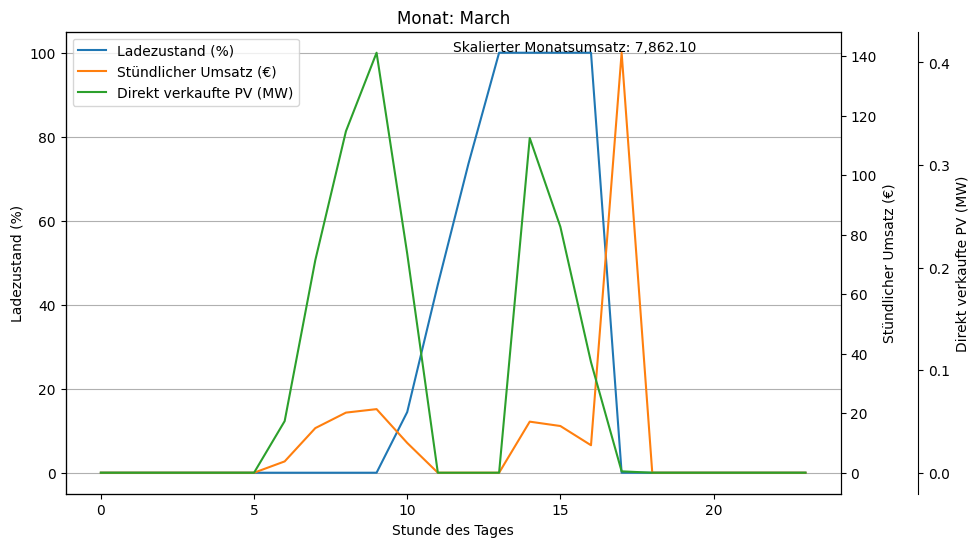

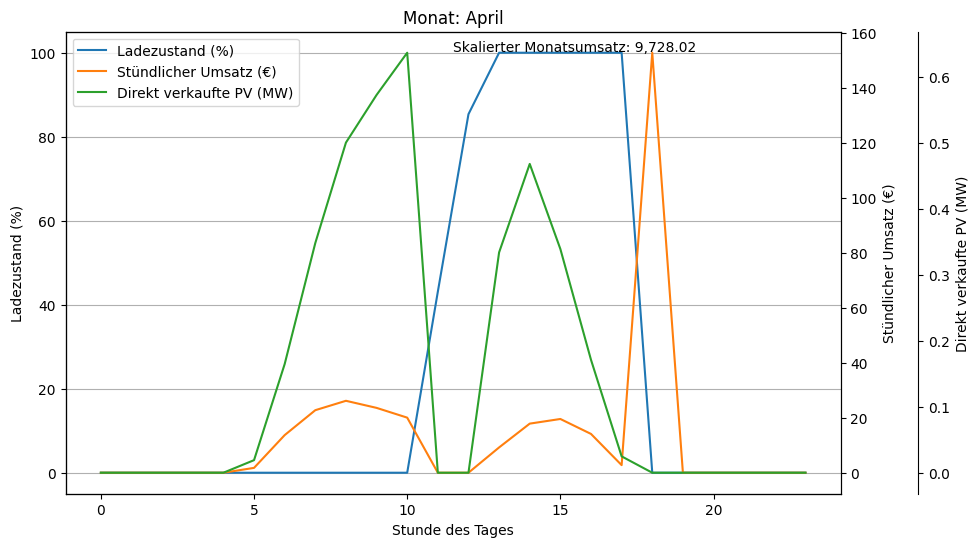

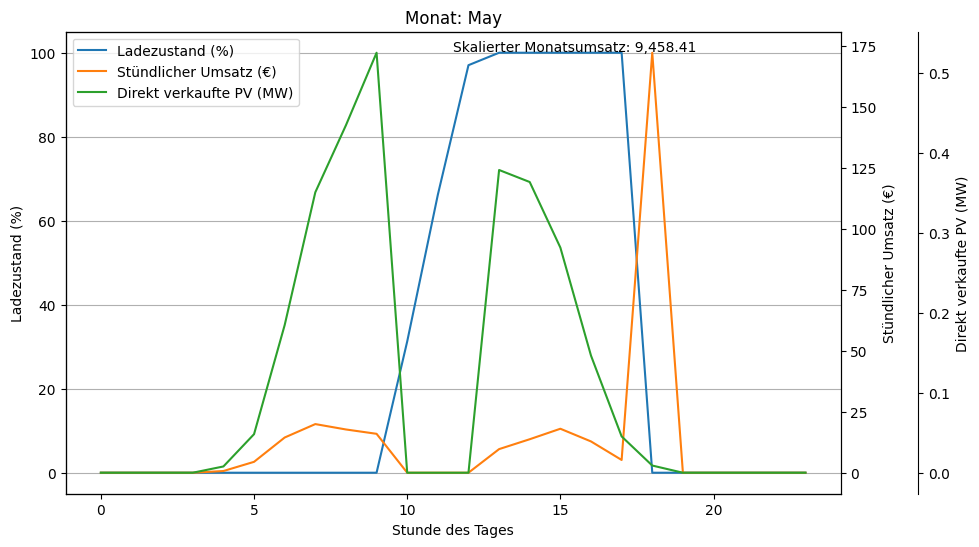

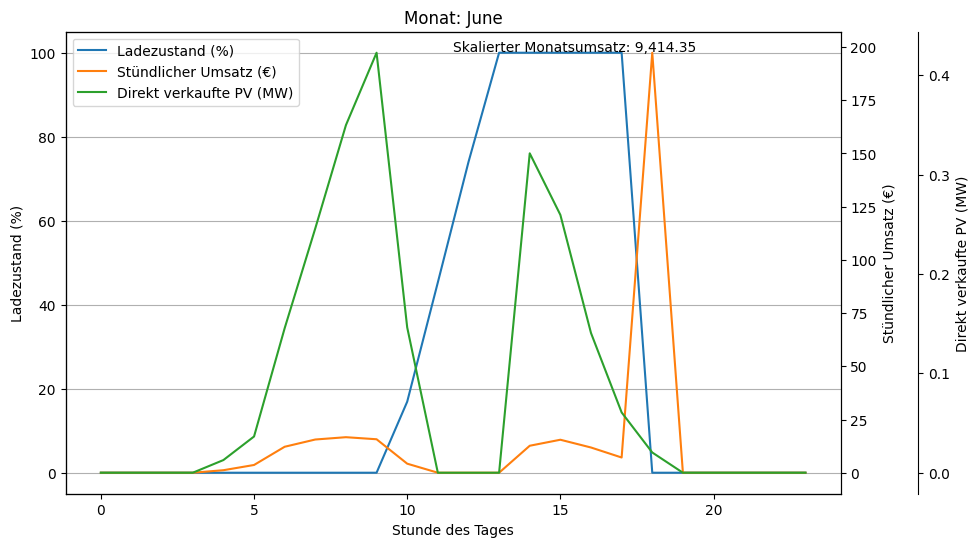

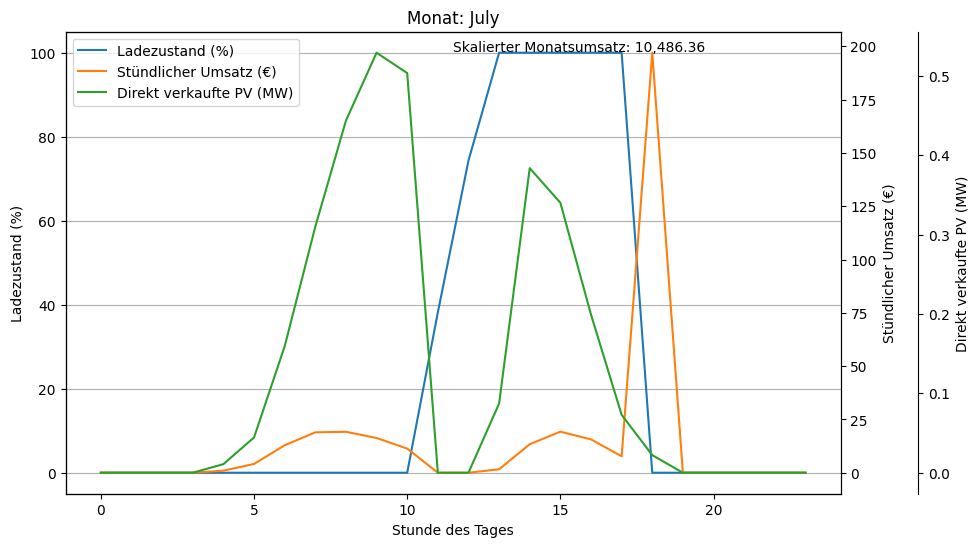

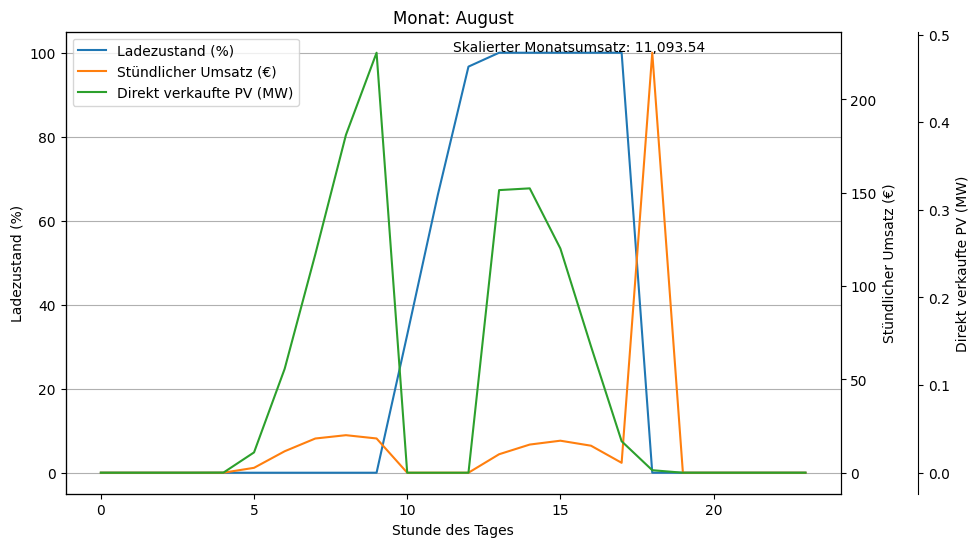

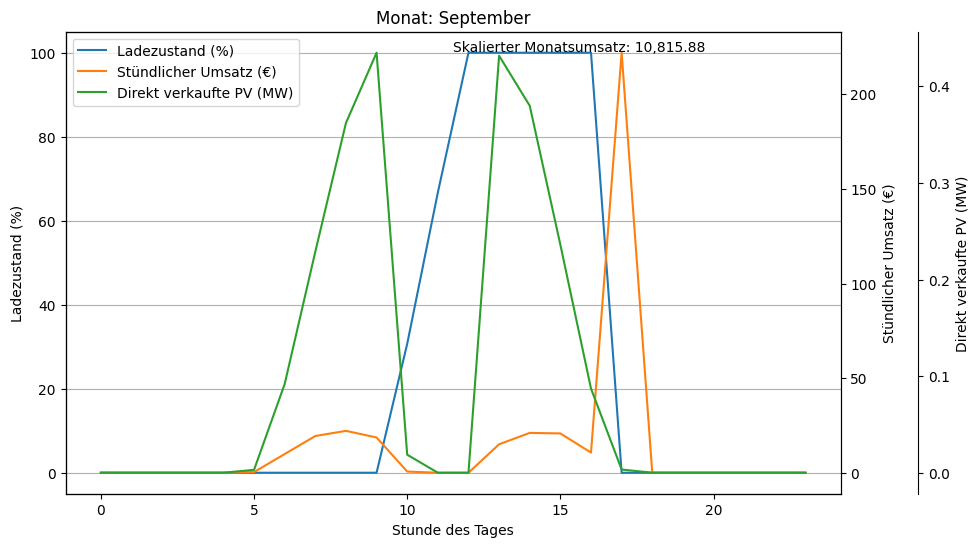

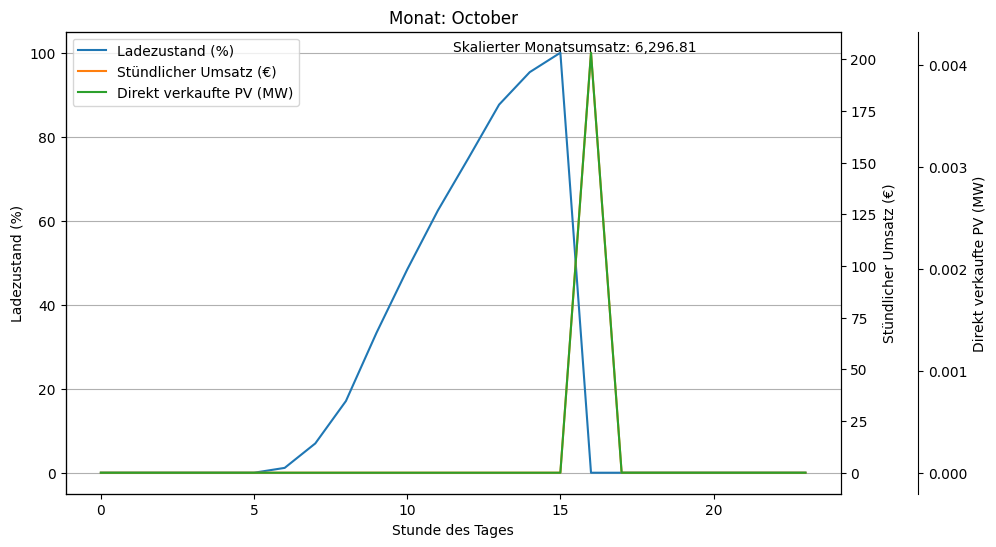

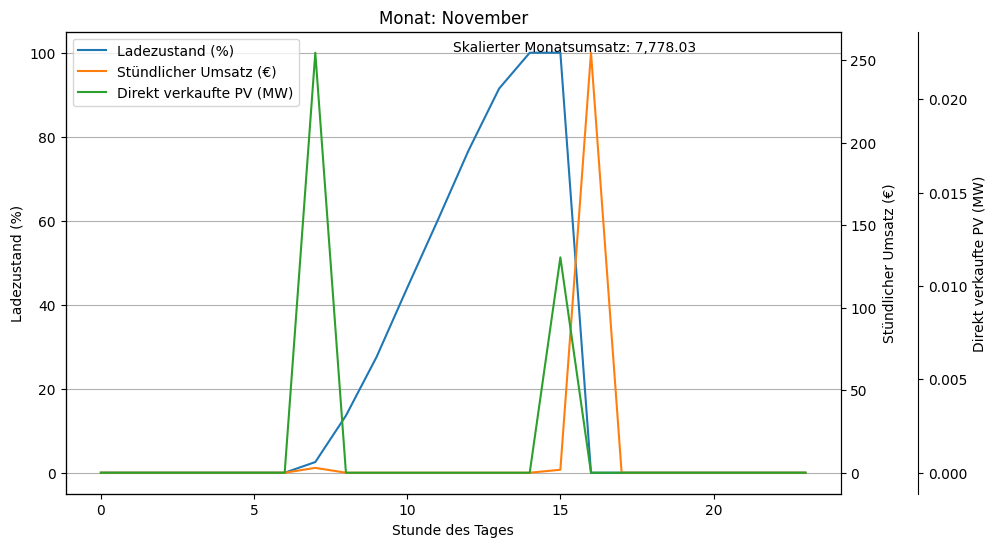

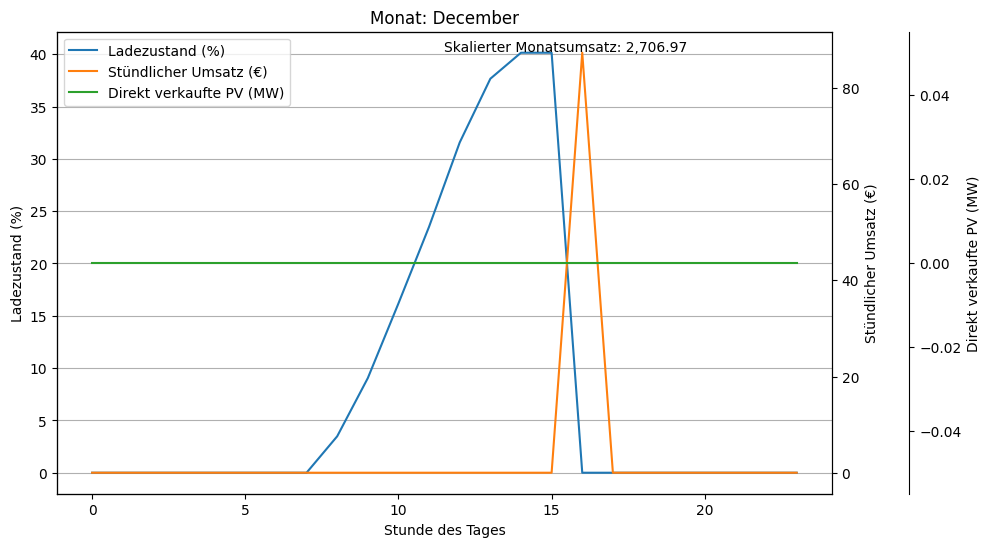

In [54]:
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Convert the Month columns to an ordered categorical
results_df["Month"] = pd.Categorical(results_df["Month"], categories=month_order, ordered=True)
monthly_revenue_df["Month"] = pd.Categorical(monthly_revenue_df["Month"], categories=month_order, ordered=True)
monthly_revenue_df.sort_values("Month", inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(monthly_revenue_df["Month"], monthly_revenue_df["Scaled_Monthly_Revenue"])
plt.title("Skalierter Monatsumsatz (Alle Monate)")
plt.xlabel("Monat")
plt.ylabel("Skalierter Monatsumsatz")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

for month in monthly_revenue_df["Month"]:
    # Filter für diesen Monat
    monthly_data = results_df[results_df["Month"] == month].copy()
    monthly_data["Hour"] = monthly_data.index % 24

    # Batteriekapazität gegen Null absichern
    battery_capacity_mwh = max(optimal_battery_energy, 1e-9)

    # Ladezustand in %
    monthly_data["SoC_percent"] = (monthly_data["SoC"] / battery_capacity_mwh) * 100.0

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 1) SoC (%) auf Achse 1 (links)
    line1 = ax1.plot(
        monthly_data["Hour"],
        monthly_data["SoC_percent"],
        color='C0',
        label='Ladezustand (%)'
    )
    ax1.set_xlabel("Stunde des Tages")
    ax1.set_ylabel("Ladezustand (%)")
    ax1.grid(axis='y')
    ax2 = ax1.twinx()
    line2 = ax2.plot(
        monthly_data["Hour"],
        monthly_data["Hourly_Revenue"],
        color='C1',
        label='Stündlicher Umsatz (€)'
    )
    ax2.set_ylabel("Stündlicher Umsatz (€)")
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    line3 = ax3.plot(
        monthly_data["Hour"],
        monthly_data["Sell_Direct"],
        color='C2',
        label='Direkt verkaufte PV (MW)'
    )
    ax3.set_ylabel("Direkt verkaufte PV (MW)")

    # Gemeinsame Legende
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

    # Textbox mit Monatsumsatz
    scaled_revenue = monthly_revenue_df.loc[
        monthly_revenue_df["Month"] == month, "Scaled_Monthly_Revenue"
    ].values[0]
    text_str = f"Skalierter Monatsumsatz: {scaled_revenue:,.2f}"
    ax1.text(
        0.5, 0.95,
        text_str,
        transform=ax1.transAxes,
        verticalalignment='bottom'
    )
    plt.title(f"Monat: {month}")

    plt.show()
